# Writing like Shakespeare

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-8.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement a Shakespeare poem generator using [Long Short-Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) cells.

## Import libraries

In [1]:
import io
import numpy as np
from keras import Sequential, Input, layers, initializers
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

2024-08-01 16:55:43.923259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:55:43.923296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:55:43.925012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 16:55:43.932900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the data

In [2]:
!wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Sequence_Models/Week1/Labs/data/shakespeare.txt

## Load the data

In [3]:
text = io.open('./shakespeare.txt', encoding='utf-8').read().lower()
print(text[:1000] + "...")

the sonnets

by william shakespeare

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou contracted to thine own bright eyes,
feed'st thy light's flame with self-substantial fuel,
making a famine where abundance lies,
thy self thy foe, to thy sweet self too cruel:
thou that art now the world's fresh ornament,
and only herald to the gaudy spring,
within thine own bud buriest thy content,
and tender churl mak'st waste in niggarding:
pity the world, or else this glutton be,
to eat the world's due, by the grave and thee.

when forty winters shall besiege thy brow,
and dig deep trenches in thy beauty's field,
thy youth's proud livery so gazed on now,
will be a tattered weed of small worth held:  
then being asked, where all thy beauty lies,
where all the treasure of thy lusty days;
to say within thine own deep sunken eyes,
were an all-eating shame, and thriftless prais

In [4]:
chars = sorted(list(set(text)))
print('Number of unique characters in the corpus:', len(chars))

Number of unique characters in the corpus: 38


## Create the training set

In [5]:
def build_data(text, Tx=40, stride=3):
    """
    Create a training set by scanning a window of size Tx over the text corpus, with stride 3.
    
    Arguments:
    text -- string, corpus of Shakespearian poem
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels
    """
    
    X = []
    Y = []

    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    
    print('Number of training examples:', len(X))
    
    return X, Y

def vectorization(X, Y, n_x, char_indices, Tx=40):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))
    """
    
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=bool)
    y = np.zeros((m, n_x), dtype=bool)

    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1

        y[i, char_indices[Y[i]]] = 1
        
    return x, y 

In [6]:
Tx = 40
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
X, Y = build_data(text, Tx, stride=3)
x, y = vectorization(X, Y, n_x=len(chars), char_indices=char_indices) 

Number of training examples: 31412


## Create the model

In [7]:
model = Sequential([Input(shape=(40, 38)),
                     layers.LSTM(units=128, recurrent_activation="hard_sigmoid", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform"), return_sequences=True),
                     layers.Dropout(rate=0.5),
                     layers.LSTM(units=128, recurrent_activation="hard_sigmoid", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform")),
                     layers.Dropout(rate=0.5),
                     layers.Dense(units=38, activation="linear", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform")),
                     layers.Activation(activation="softmax")])

model.summary()

2024-08-01 16:55:47.654366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2119 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 128)        │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │         4,902 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,990 (867.15 KB)

 Trainable params: 221,990 (867.15 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

## Fit the model

In [9]:
history = model.fit(x, y, batch_size=128, epochs=200, verbose=0)

I0000 00:00:1722552950.405195  235368 service.cc:145] XLA service 0x6544c23ad490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722552950.405220  235368 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-01 16:55:50.457098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 16:55:50.913125: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1722552959.030936  235421 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_58', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1722552959.772152  235418 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_53', 1796 bytes spill stores, 1796 bytes spill loads

I0000 00:00:

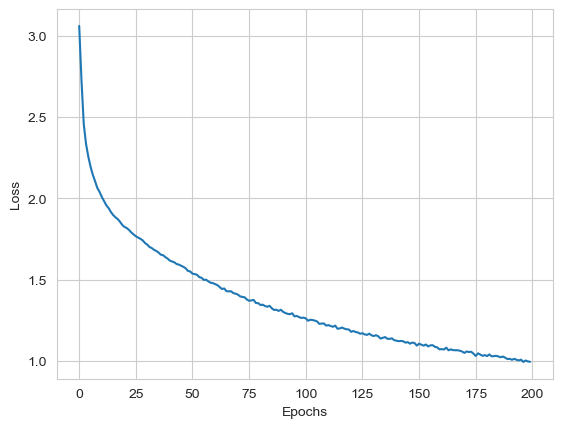

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluate the model

Helper function to sample an index from a probability array.

In [11]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p=probas.ravel())

    return out

In [12]:
def generate_output(length=500):
    generated = ''
    usr_input = input("Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: ")
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower() # zero pad the sentence to Tx characters
    generated += usr_input 

    sys.stdout.write("Here is your poem: \n\n") 
    sys.stdout.write(usr_input)

    for i in range(length):
        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature=1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

    sys.stdout.write("...")

In [13]:
generate_output()

Here is your poem: 

Hellow,
they fair broud thy world do umestain thee,
that for the weir for my rize eyes to mece.
mise you what with loids to the self you for gree,
but will beauty, lott the hin thing, so thou tomguin,
and proudss dighing terest the beaso thee,
the pear me sap am congauncin cisto thee,
on made thy sulf-woilled fair, seaton from her,
ill age and him pracich the prise, lone dade,
which thee with i am, which their prazent
with thy soul baddsting to see,
and sould the hald mose some not thy self,
thy sulf...

In [14]:
!rm ./shakespeare.txt